In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shapes -> X_train: (1647530, 24) X_test: (411883, 24) y_train: (1647530,) y_test: (411883,)
Detected normal label (treated as normal): 7
Training IsolationForest on normal-only subset shape: (1567816, 24)
Saved IF model.

Confusion matrix:
 [[372546  19408]
 [  8341  11588]]

Classification report:
               precision    recall  f1-score   support

      normal       0.98      0.95      0.96    391954
      attack       0.37      0.58      0.46     19929

    accuracy                           0.93    411883
   macro avg       0.68      0.77      0.71    411883
weighted avg       0.95      0.93      0.94    411883

Accuracy: 0.9326289261756373
ROC-AUC (scores): 0.9177407438809689


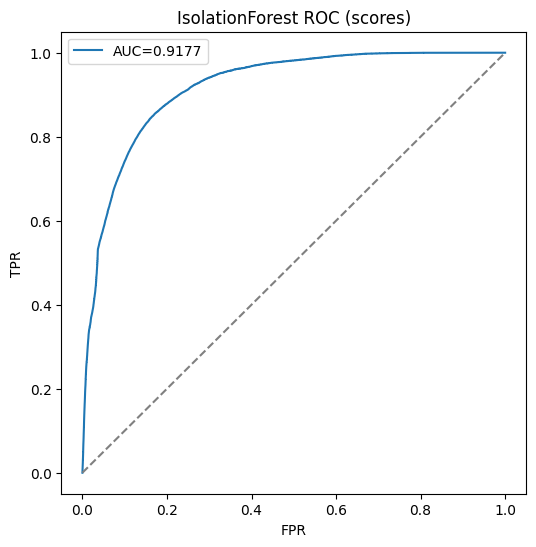


Best threshold on test (max F1): 8.003486e-03, best F1: 0.4724
Confusion (best-thr):
 [[377527  14427]
 [  9305  10624]]
              precision    recall  f1-score   support

      normal       0.98      0.96      0.97    391954
      attack       0.42      0.53      0.47     19929

    accuracy                           0.94    411883
   macro avg       0.70      0.75      0.72    411883
weighted avg       0.95      0.94      0.95    411883

Saved IF test scores for ensemble: /content/drive/MyDrive/zeusOps/models/if_test_scores.pkl


In [7]:
# IsolationForest — fixed, robust training & eval (use as drop-in)
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve, f1_score
)
import matplotlib.pyplot as plt

DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/UNSW-NB15")
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
MODEL_DIR.mkdir(exist_ok=True)

# --- Load (may be DataFrame/Series) ---
X_train = pd.read_pickle(DATA_DIR / "unsw_x_train.pkl")
X_test  = pd.read_pickle(DATA_DIR / "unsw_x_test.pkl")
y_train = pd.read_pickle(DATA_DIR / "unsw_y_train.pkl")
y_test  = pd.read_pickle(DATA_DIR / "unsw_y_test.pkl")

# --- Convert to numpy and normalize shapes ---
# X: 2D (n_samples, n_features)
if hasattr(X_train, "values"):
    X_train = X_train.values
if hasattr(X_test, "values"):
    X_test = X_test.values

# y: 1D (n_samples,)
if hasattr(y_train, "values"):
    y_train = y_train.values
y_train = np.asarray(y_train).ravel()

if hasattr(y_test, "values"):
    y_test = y_test.values
y_test = np.asarray(y_test).ravel()

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape,
      "y_train:", y_train.shape, "y_test:", y_test.shape)

# --- Sanity asserts ---
assert X_train.ndim == 2 and X_test.ndim == 2, "X must be 2D (n_samples, n_features)"
assert y_train.ndim == 1 and y_test.ndim == 1, "y must be 1D"
assert X_train.shape[0] == y_train.shape[0], "Row mismatch between X_train and y_train"
assert X_test.shape[0] == y_test.shape[0], "Row mismatch between X_test and y_test"

# --- Build binary labels (0 = normal, 1 = attack) ---
# detect majority label (your normal)
unique, counts = np.unique(y_train, return_counts=True)
normal_label = unique[np.argmax(counts)]
print("Detected normal label (treated as normal):", normal_label)

y_train_binary = np.where(y_train == normal_label, 0, 1)
y_test_binary  = np.where(y_test == normal_label, 0, 1)

# --- Train IF only on normal samples (mask rows properly) ---
mask_normals = (y_train_binary == 0)
X_train_normals = X_train[mask_normals]
print("Training IsolationForest on normal-only subset shape:", X_train_normals.shape)

# choose final params for ensemble usage (stable scores)
n_estimators = 400
max_samples = 0.6
# contamination for scoring threshold — you can set to expected test attack fraction
contamination = float(max(0.0001, y_test_binary.mean()))  # fallback tiny if zero

iso = IsolationForest(
    n_estimators=n_estimators,
    max_samples=max_samples,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_normals)

# Save model
joblib.dump(iso, MODEL_DIR / f"unsw_if_{n_estimators}_{int(max_samples*100)}_{contamination:.4f}.pkl", compress=3)
print("Saved IF model.")

# --- Predictions & scores on test set ---
y_pred = iso.predict(X_test)            # 1 = inlier (normal), -1 = outlier (anomaly)
y_pred_binary = np.where(y_pred == 1, 0, 1)    # convert to 0=normal,1=attack

# continuous anomaly score (higher → more anomalous)
y_scores = -iso.decision_function(X_test)

# --- Metrics (binary) ---
print("\nConfusion matrix:\n", confusion_matrix(y_test_binary, y_pred_binary))
print("\nClassification report:\n", classification_report(y_test_binary, y_pred_binary, target_names=["normal","attack"]))
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
auc = roc_auc_score(y_test_binary, y_scores)
print("ROC-AUC (scores):", auc)

# ROC curve plot (optional)
fpr, tpr, _ = roc_curve(y_test_binary, y_scores)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("IsolationForest ROC (scores)")
plt.legend(); plt.show()

# --- Find best threshold on scores (maximize F1) ---
thr_grid = np.linspace(y_scores.min(), y_scores.max(), 200)
best_f1, best_thr = -1.0, None
for thr in thr_grid:
    preds = (y_scores >= thr).astype(int)   # >= thr = anomalous
    f1 = f1_score(y_test_binary, preds, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"\nBest threshold on test (max F1): {best_thr:.6e}, best F1: {best_f1:.4f}")

# apply best threshold
y_pred_best = (y_scores >= best_thr).astype(int)
print("Confusion (best-thr):\n", confusion_matrix(y_test_binary, y_pred_best))
print(classification_report(y_test_binary, y_pred_best, target_names=["normal","attack"]))

# --- Save scores + preds for ensemble ---
df_scores = pd.DataFrame({
    "if_score": y_scores,
    "if_pred_default": y_pred_binary,
    "if_pred_best_thr": y_pred_best,
    "y_test_binary": y_test_binary
})
df_scores.to_pickle(MODEL_DIR / "if_test_scores.pkl")
print("Saved IF test scores for ensemble:", MODEL_DIR / "if_test_scores.pkl")
